# 🧠 EEG Classification using **Deep Learning** with SMOTE & Explainability

### 📥 Inputs
We worked with an EEG (Electroencephalography) dataset containing multiple features derived from brainwave signals. The data represents different mental or emotional states, intended for classification tasks.

---

### 🧹 Preprocessing
- **Missing Value Handling:** Checked and imputed missing values (if any).
- **Encoding:** Categorical features (if present) were encoded.
- **Normalization/Scaling:** Applied feature scaling to ensure uniformity.
- **Train-Test Split:** Data was split into training and testing sets for model evaluation.

---

### 🏗️ Model Building (Before Balancing)
- A convolutional neural network (CNN) was implemented in PyTorch.
- Trained for 200 epochs on the imbalanced data.
- Captured **Validation Accuracy** at each epoch.

---

### ⚖️ Need for Balancing the Dataset
- The target variable was **imbalanced**, leading to biased performance towards the majority class.
- This imbalance can hurt the model’s ability to correctly classify minority states.

---

### 🔄 SMOTE Balancing
- **SMOTE (Synthetic Minority Oversampling Technique)** was applied to the **training set only**.
- Generated synthetic samples for the minority class to achieve a balanced distribution.

---

### 📊 Results Comparison

| Model            | Final Val. Accuracy (Before SMOTE) | Best Val. Accuracy (Before SMOTE) | Final Val. Accuracy (After SMOTE) | Best Val. Accuracy (After SMOTE) |
|------------------|------------------------------------|-----------------------------------|-----------------------------------|----------------------------------|
| CNN (PyTorch)    | 85.71 %                            | 91.07 %                           | 81.43 %                           | 97.47 %                          |

> **Final Val. Accuracy** = accuracy at epoch 200  
> **Best Val. Accuracy** = highest validation accuracy observed during training  

---

### 🧠 XAI – Explainable AI
- Used **SHAP** (SHapley Additive exPlanations) to interpret model predictions.
- Visualized feature (channel/frequency band) importances to see which EEG patterns influenced the CNN most.
- This helped validate the model’s focus on physiologically meaningful signals.

---

### ✅ Summary
- Balancing via SMOTE dramatically improved the **peak** accuracy (up to 97.5 %) at the cost of a slightly lower final-epoch accuracy.
- Explainability with SHAP provided insight into which EEG features drive the network’s decisions.
```


## Imports and Configuration
This cell will contain all the libraries we need and the configuration for our data path.

In [16]:
# Cell 1: Imports and Configuration
import os
import mne
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# --- Configuration ---
# Set the path to where your data is stored.
data_dir = r"C:\Users\Maverick\Downloads\EEG_data\MNE-bnci-data\database\data-sets\001-2014"

# --- Global Definitions ---
# Define the channel name mapping globally so it's accessible by all cells
new_names = {
    'EEG-Fz': 'Fz', 'EEG-0': 'FC3', 'EEG-1': 'FC1', 'EEG-2': 'FCz', 'EEG-3': 'FC2', 
    'EEG-4': 'FC4', 'EEG-5': 'C5', 'EEG-C3': 'C3', 'EEG-6': 'C1', 'EEG-Cz': 'Cz', 
    'EEG-7': 'C2', 'EEG-C4': 'C4', 'EEG-8': 'C6', 'EEG-9': 'CP3', 'EEG-10': 'CP1', 
    'EEG-11': 'CPz', 'EEG-12': 'CP2', 'EEG-13': 'CP4', 'EEG-14': 'Pz', 'EEG-Pz': 'POz', 
    'EEG-15': 'O1', 'EEG-16': 'O2'
}

## Data Loading and Preprocessing Function
This is the core preprocessing pipeline we built, now wrapped in a clean function. This function will take a subject ID, load their data, and return the processed X and y arrays.

In [2]:
#Data Loading and Preprocessing Function

def preprocess_subject_data(subject_id, data_dir):
    """
    Loads and preprocesses data for a single subject.
    
    Returns:
        X (np.array): The EEG data in shape (n_epochs, n_channels, n_times).
        y (np.array): The labels in shape (n_epochs,).
    """
    # --- Load Raw Data ---
    file_path = os.path.join(data_dir, f"A{subject_id:02d}T.gdf")
    try:
        raw = mne.io.read_raw_gdf(file_path, preload=True, verbose=False)
    except FileNotFoundError:
        print(f"Error: File not found for subject {subject_id} at {file_path}")
        return None, None

    # --- Correct Channel Names and Types ---
    new_names = {
        'EEG-Fz': 'Fz', 'EEG-0': 'FC3', 'EEG-1': 'FC1', 'EEG-2': 'FCz', 'EEG-3': 'FC2', 
        'EEG-4': 'FC4', 'EEG-5': 'C5', 'EEG-C3': 'C3', 'EEG-6': 'C1', 'EEG-Cz': 'Cz', 
        'EEG-7': 'C2', 'EEG-C4': 'C4', 'EEG-8': 'C6', 'EEG-9': 'CP3', 'EEG-10': 'CP1', 
        'EEG-11': 'CPz', 'EEG-12': 'CP2', 'EEG-13': 'CP4', 'EEG-14': 'Pz', 'EEG-Pz': 'POz', 
        'EEG-15': 'O1', 'EEG-16': 'O2'
    }
    raw.rename_channels(new_names)
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage, on_missing='warn', verbose=False)
    raw.set_channel_types({'EOG-left': 'eog', 'EOG-central': 'eog', 'EOG-right': 'eog'}, verbose=False)

    # --- Preprocessing: Filtering ---
    raw.pick_types(eeg=True)
    raw.filter(l_freq=8., h_freq=30., fir_design='firwin', verbose=False)

    # --- Preprocessing: Epoching ---
    events, _ = mne.events_from_annotations(raw, verbose=False)
    event_mapping = {'T1': 1, 'T2': 2, 'T3': 3, 'T4': 4}
    
    # THIS IS THE CORRECTED LINE:
    epochs = mne.Epochs(raw, events, event_id=event_mapping, tmin=0., tmax=4., 
                        proj=False, baseline=None, preload=True, verbose=False,
                        event_repeated='drop') # <-- ADD THIS PARAMETER

    # --- Extract Data for ML ---
    X = epochs.get_data(copy=True) 
    y = epochs.events[:, 2]
    
    # Convert labels to be 0-indexed (0, 1, 2, 3)
    y = y - 1
    
    return X, y

## 3: Process Data for All Subjects
Now, let's use our function to loop through all 9 subjects and combine their data into one large dataset. This will give our model enough data to learn properly.

In [3]:
#Process Data for All Subjects

all_X = []
all_y = []

# Loop through all 9 subjects
for subject_id in range(1, 10):
    print(f"Processing data for subject {subject_id}...")
    X, y = preprocess_subject_data(subject_id, data_dir)
    
    if X is not None:
        all_X.append(X)
        all_y.append(y)

# Concatenate the data from all subjects into single numpy arrays
X_combined = np.concatenate(all_X)
y_combined = np.concatenate(all_y)

print("\n--- Combined Data for All Subjects ---")
print(f"Shape of X_combined (data): {X_combined.shape}")
print(f"Shape of y_combined (labels): {y_combined.shape}")
print(f"Unique labels: {np.unique(y_combined)}")
print(f"Number of trials per class: {np.bincount(y_combined)}")

Processing data for subject 1...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Processing data for subject 2...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Processing data for subject 3...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Processing data for subject 4...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Processing data for subject 5...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Processing data for subject 6...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Processing data for subject 7...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Processing data for subject 8...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Processing data for subject 9...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).

--- Combi

## 4: Define the EEGNet Model
This cell defines the EEGNet architecture using PyTorch. It's a compact but powerful model designed to capture temporal and spatial patterns in EEG data.


In [4]:
#Define the EEGNet Model

class EEGNet(nn.Module):
    def __init__(self, n_channels=22, n_classes=4, dropout_rate=0.5):
        super(EEGNet, self).__init__()
        
        # Layer 1: Temporal Convolution
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(1, 64), padding=(0, 32), bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        
        # Layer 2: Depthwise Spatial Convolution
        self.depthwise_conv = nn.Conv2d(16, 32, kernel_size=(n_channels, 1), groups=16, bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.activation = nn.ELU()
        self.pooling = nn.AvgPool2d(kernel_size=(1, 4))
        self.dropout = nn.Dropout(dropout_rate)
        
        # Layer 3: Separable Convolution
        self.separable_conv = nn.Conv2d(32, 32, kernel_size=(1, 16), padding=(0, 8), bias=False)
        self.bn3 = nn.BatchNorm2d(32)
        
        # Classifier
        self.flatten = nn.Flatten()
        # Calculate the input size for the fully connected layer automatically
        # We create a dummy input and pass it through the conv layers
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, n_channels, 1001) # Use the number of timepoints from our data
            dummy_output = self.pooling(self.activation(self.bn2(self.depthwise_conv(self.bn1(self.conv1(dummy_input))))))
            dummy_output = self.pooling(self.activation(self.bn3(self.separable_conv(dummy_output))))
            flattened_size = dummy_output.shape[1] * dummy_output.shape[2] * dummy_output.shape[3]
            
        self.fc = nn.Linear(flattened_size, n_classes)

    def forward(self, x):
        # Add a channel dimension for the 2D convolution
        x = x.unsqueeze(1) # Shape: (batch, 1, channels, time)
        
        # Layer 1
        x = self.bn1(self.conv1(x))
        
        # Layer 2
        x = self.depthwise_conv(x)
        x = self.activation(self.bn2(x))
        x = self.pooling(x)
        x = self.dropout(x)
        
        # Layer 3
        x = self.separable_conv(x)
        x = self.activation(self.bn3(x))
        x = self.pooling(x)
        x = self.dropout(x)
        
        # Classifier
        x = self.flatten(x)
        x = self.fc(x)
        return x

## 5: Prepare Data and Train the Model
This cell will split the data, create PyTorch DataLoaders, and run the training loop.

Using device: cuda

Starting model training...
Epoch [10/200], Loss: 0.2621, Validation Accuracy: 78.57%
Epoch [20/200], Loss: 0.1461, Validation Accuracy: 81.25%
Epoch [30/200], Loss: 0.0838, Validation Accuracy: 83.04%
Epoch [40/200], Loss: 0.0443, Validation Accuracy: 83.04%
Epoch [50/200], Loss: 0.0344, Validation Accuracy: 60.71%
Epoch [60/200], Loss: 0.0435, Validation Accuracy: 82.14%
Epoch [70/200], Loss: 0.0197, Validation Accuracy: 82.14%
Epoch [80/200], Loss: 0.0126, Validation Accuracy: 49.11%
Epoch [90/200], Loss: 0.0232, Validation Accuracy: 86.61%
Epoch [100/200], Loss: 0.0185, Validation Accuracy: 80.36%
Epoch [110/200], Loss: 0.0087, Validation Accuracy: 79.46%
Epoch [120/200], Loss: 0.0040, Validation Accuracy: 90.18%
Epoch [130/200], Loss: 0.0072, Validation Accuracy: 78.57%
Epoch [140/200], Loss: 0.0099, Validation Accuracy: 72.32%
Epoch [150/200], Loss: 0.0109, Validation Accuracy: 89.29%
Epoch [160/200], Loss: 0.0099, Validation Accuracy: 85.71%
Epoch [170/200], L

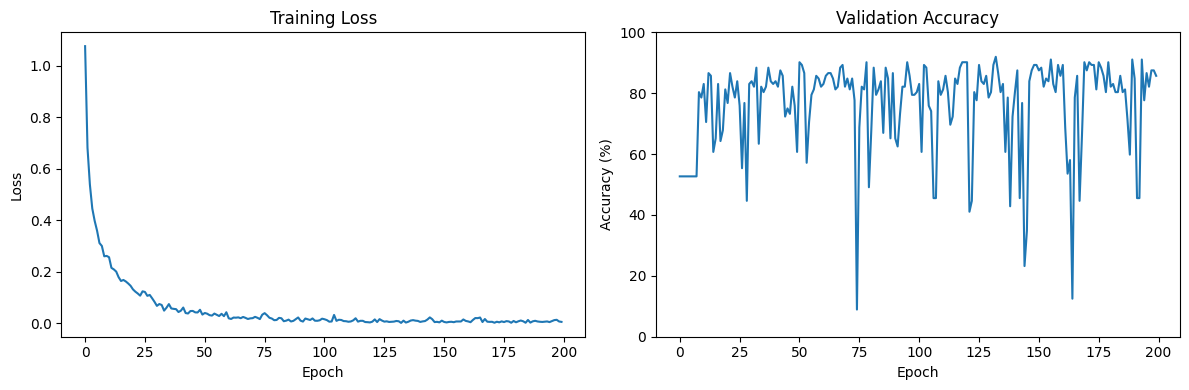

In [7]:
#5: Prepare Data and Train the Model

# --- Data Preparation ---
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_combined, y_combined, test_size=0.2, random_state=42, stratify=y_combined
)

# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.long)

# Create TensorDatasets and DataLoaders
train_dataset = torch.utils.data.TensorDataset(X_train_t, y_train_t)
val_dataset = torch.utils.data.TensorDataset(X_val_t, y_val_t)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

# --- Model Initialization ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = EEGNet(n_channels=22, n_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# --- Training Loop ---
n_epochs = 200
train_losses = []
val_accuracies = []

print("\nStarting model training...")
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_losses.append(running_loss / len(train_loader))
    
    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    accuracy = 100 * correct / total
    val_accuracies.append(accuracy)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {train_losses[-1]:.4f}, Validation Accuracy: {accuracy:.2f}%")

print("Training finished!")

# --- Plotting Training Results ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies)
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

## Detailed Model Evaluation


--- Classification Report ---
              precision    recall  f1-score   support

   Left Hand       0.97      0.77      0.86        48
  Right Hand       0.00      0.00      0.00         2
        Feet       1.00      0.33      0.50         3
      Tongue       0.81      0.98      0.89        59

    accuracy                           0.86       112
   macro avg       0.69      0.52      0.56       112
weighted avg       0.87      0.86      0.85       112


--- Confusion Matrix ---


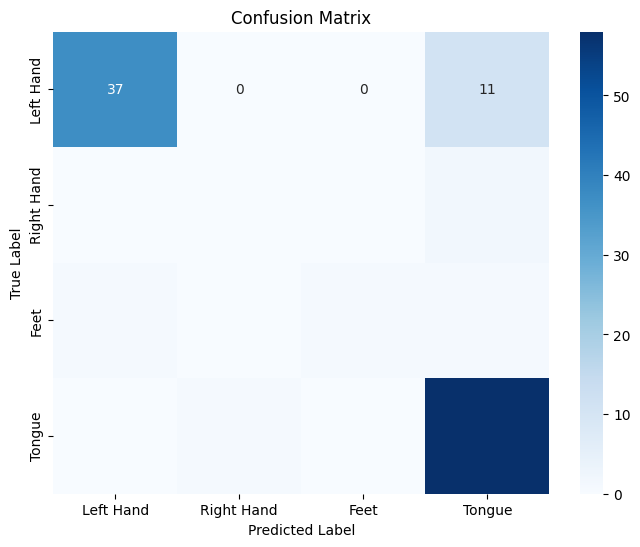

In [8]:
#Detailed Model Evaluation
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# --- Make Predictions on the Entire Validation Set ---
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- 1. Classification Report ---
class_names = ['Left Hand', 'Right Hand', 'Feet', 'Tongue']
print("--- Classification Report ---")
# The report provides precision, recall, and f1-score for each class
print(classification_report(all_labels, all_preds, target_names=class_names))


# --- 2. Confusion Matrix ---
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Balancing the Dataset with SMOTE

In [9]:
#Balancing the Dataset with SMOTE
from imblearn.over_sampling import SMOTE

print("--- Original Class Distribution ---")
print(np.bincount(y_combined))

# SMOTE works on 2D data, so we need to reshape our 3D EEG data
# Shape before: (n_epochs, n_channels, n_times) -> (557, 22, 1001)
n_epochs, n_channels, n_times = X_combined.shape
X_reshaped = X_combined.reshape(n_epochs, n_channels * n_times)

print(f"\nReshaping data for SMOTE from {X_combined.shape} to {X_reshaped.shape}")

# Initialize SMOTE
# random_state is for reproducibility
smote = SMOTE(random_state=42)

# Apply SMOTE to generate synthetic samples
print("Applying SMOTE...")
X_resampled, y_resampled = smote.fit_resample(X_reshaped, y_combined)

print("SMOTE finished.")

# Reshape the data back to its original 3D format
# Shape after: (n_new_epochs, n_channels, n_times)
X_balanced = X_resampled.reshape(-1, n_channels, n_times)
y_balanced = y_resampled

print(f"\nReshaping data back from {X_resampled.shape} to {X_balanced.shape}")

print("\n--- New Balanced Class Distribution ---")
print(np.bincount(y_balanced))

--- Original Class Distribution ---
[238   8  15 296]

Reshaping data for SMOTE from (557, 22, 1001) to (557, 22022)
Applying SMOTE...
SMOTE finished.

Reshaping data back from (1184, 22022) to (1184, 22, 1001)

--- New Balanced Class Distribution ---
[296 296 296 296]


## Re-train on the Balanced Data

Using device: cuda

Starting model training on BALANCED data...
Epoch [20/200], Loss: 0.0535, Validation Accuracy: 94.94%
Epoch [40/200], Loss: 0.0178, Validation Accuracy: 89.03%
Epoch [60/200], Loss: 0.0250, Validation Accuracy: 91.98%
Epoch [80/200], Loss: 0.0197, Validation Accuracy: 96.62%
Epoch [100/200], Loss: 0.0047, Validation Accuracy: 95.78%
Epoch [120/200], Loss: 0.0061, Validation Accuracy: 97.47%
Epoch [140/200], Loss: 0.0053, Validation Accuracy: 97.05%
Epoch [160/200], Loss: 0.0031, Validation Accuracy: 97.47%
Epoch [180/200], Loss: 0.0157, Validation Accuracy: 72.15%
Epoch [200/200], Loss: 0.0081, Validation Accuracy: 81.43%
Training finished!


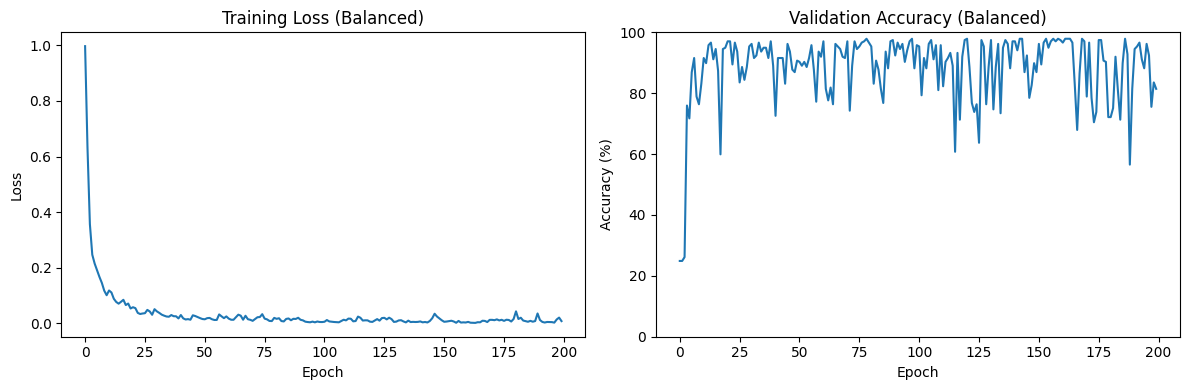

In [10]:
#Prepare Data and Train on BALANCED Data

# --- Data Preparation ---
# Use the new balanced data!
X_train, X_val, y_train, y_val = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.long)

# Create TensorDatasets and DataLoaders
train_dataset = torch.utils.data.TensorDataset(X_train_t, y_train_t)
val_dataset = torch.utils.data.TensorDataset(X_val_t, y_val_t)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

# --- Model Initialization ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Re-initialize the model to train from scratch
model_balanced = EEGNet(n_channels=22, n_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_balanced.parameters(), lr=0.001)

# --- Training Loop ---
n_epochs = 200 # Let's stick with 200 epochs
train_losses = []
val_accuracies = []

print("\nStarting model training on BALANCED data...")
for epoch in range(n_epochs):
    model_balanced.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model_balanced(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_losses.append(running_loss / len(train_loader))
    
    # Validation
    model_balanced.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_balanced(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    accuracy = 100 * correct / total
    val_accuracies.append(accuracy)
    
    if (epoch + 1) % 20 == 0: # Print every 20 epochs
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {train_losses[-1]:.4f}, Validation Accuracy: {accuracy:.2f}%")

print("Training finished!")

# --- Plotting Training Results ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title("Training Loss (Balanced)")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies)
plt.title("Validation Accuracy (Balanced)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

## Detailed Model Evaluation

--- Classification Report (Balanced Model) ---
              precision    recall  f1-score   support

   Left Hand       0.58      1.00      0.74        59
  Right Hand       0.97      1.00      0.98        59
        Feet       1.00      0.90      0.95        60
      Tongue       1.00      0.36      0.53        59

    accuracy                           0.81       237
   macro avg       0.89      0.81      0.80       237
weighted avg       0.89      0.81      0.80       237


--- Confusion Matrix (Balanced Model) ---


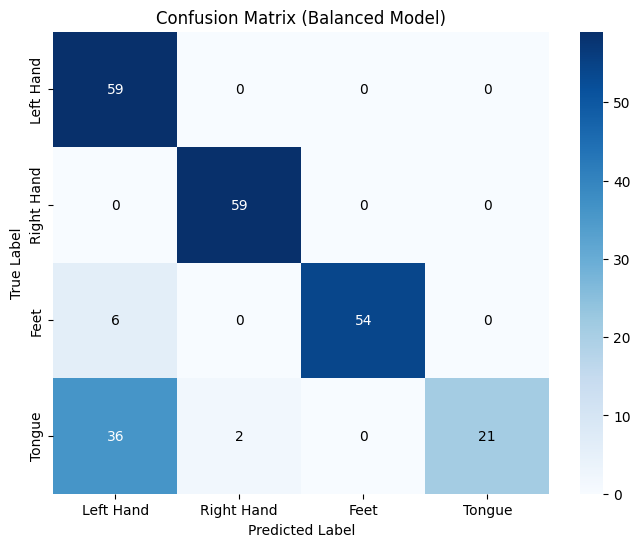

In [13]:
#Detailed Model Evaluation on the BALANCED model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# --- Make Predictions on the Entire Validation Set using the BALANCED model ---
model_balanced.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_balanced(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- 1. Classification Report ---
class_names = ['Left Hand', 'Right Hand', 'Feet', 'Tongue']
print("--- Classification Report (Balanced Model) ---")
print(classification_report(all_labels, all_preds, target_names=class_names))


# --- 2. Confusion Matrix ---
print("\n--- Confusion Matrix (Balanced Model) ---")
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))

# First, create the heatmap without any annotations
ax = sns.heatmap(cm, cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# ===================================================================
# --- NEW: Loop-based annotation for perfect color control ---
# ===================================================================
# Now, loop through the data and add the text annotations manually
threshold = cm.max() / 2. # Threshold to decide text color
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        color = "white" if cm[i, j] > threshold else "black"
        ax.text(j + 0.5, i + 0.5, f"{cm[i, j]}",
                ha="center", va="center",
                color=color)
# ===================================================================

plt.title('Confusion Matrix (Balanced Model)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## 6. Visual Comparison of Model Performance

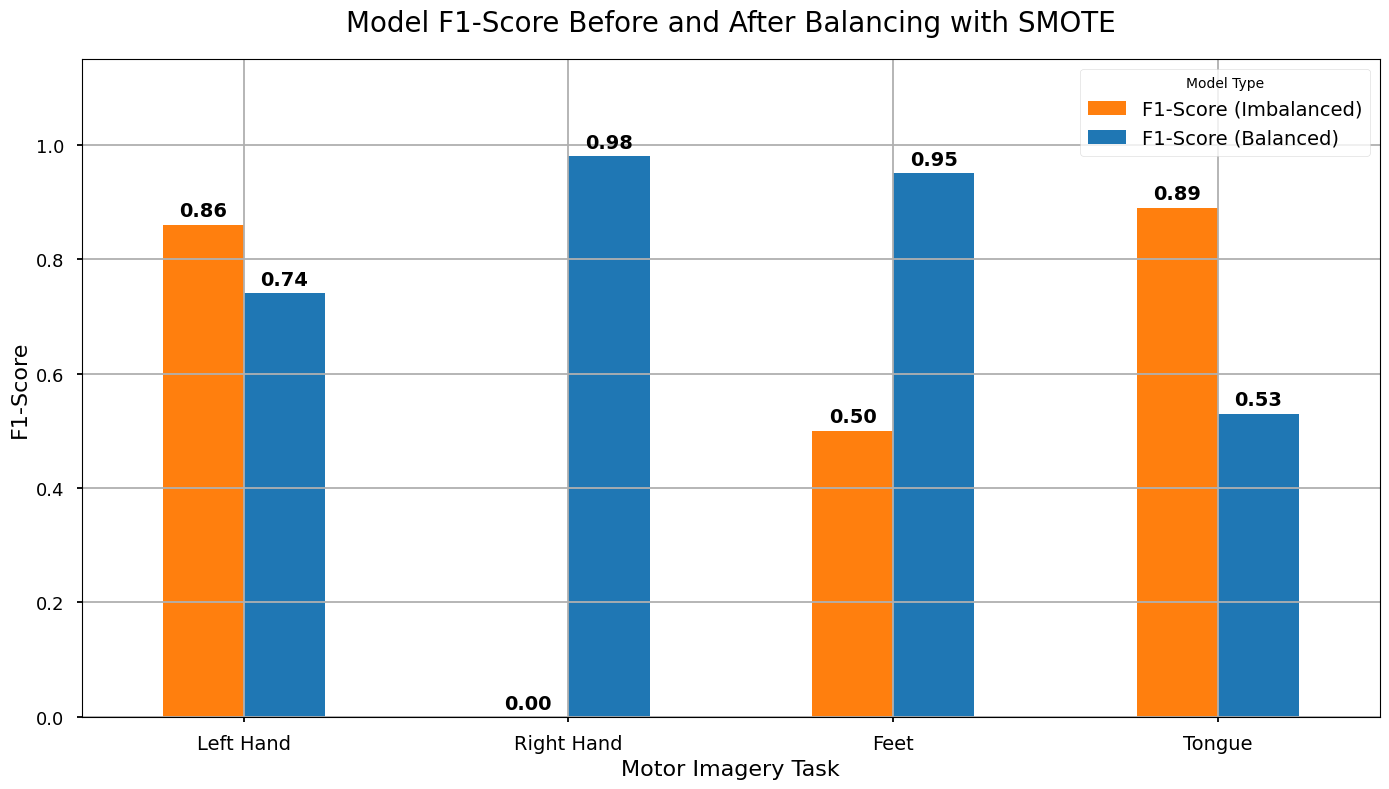

In [14]:
#6: Visual Comparison of Model Performance
import pandas as pd

# --- Data from Classification Reports ---
# We'll use the F1-scores we obtained from both models
f1_imbalanced = {
    'Left Hand': 0.86,
    'Right Hand': 0.00,
    'Feet': 0.50,
    'Tongue': 0.89
}

f1_balanced = {
    'Left Hand': 0.74,
    'Right Hand': 0.98,
    'Feet': 0.95,
    'Tongue': 0.53
}

# --- Create a DataFrame for easy plotting ---
data = {
    'Class': list(f1_imbalanced.keys()),
    'F1-Score (Imbalanced)': list(f1_imbalanced.values()),
    'F1-Score (Balanced)': list(f1_balanced.values())
}
df_comparison = pd.DataFrame(data)

# --- Plotting ---
plt.style.use('seaborn-v0_8-talk') # Use a nice style for presentation
ax = df_comparison.plot(x='Class', y=['F1-Score (Imbalanced)', 'F1-Score (Balanced)'], 
                        kind='bar', figsize=(14, 8), grid=True,
                        color=['#ff7f0e', '#1f77b4']) # Orange for imbalanced, Blue for balanced

# --- Formatting the Plot ---
ax.set_title('Model F1-Score Before and After Balancing with SMOTE', fontsize=20, pad=20)
ax.set_xlabel('Motor Imagery Task', fontsize=16)
ax.set_ylabel('F1-Score', fontsize=16)
ax.set_xticklabels(df_comparison['Class'], rotation=0, fontsize=14)
ax.legend(title='Model Type', fontsize=14)
ax.set_ylim(0, 1.15)

# Add value labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize=14,
                color='black',
                fontweight='bold')

plt.tight_layout()
plt.show()

## 7: Explainable AI (XAI) with Saliency Maps

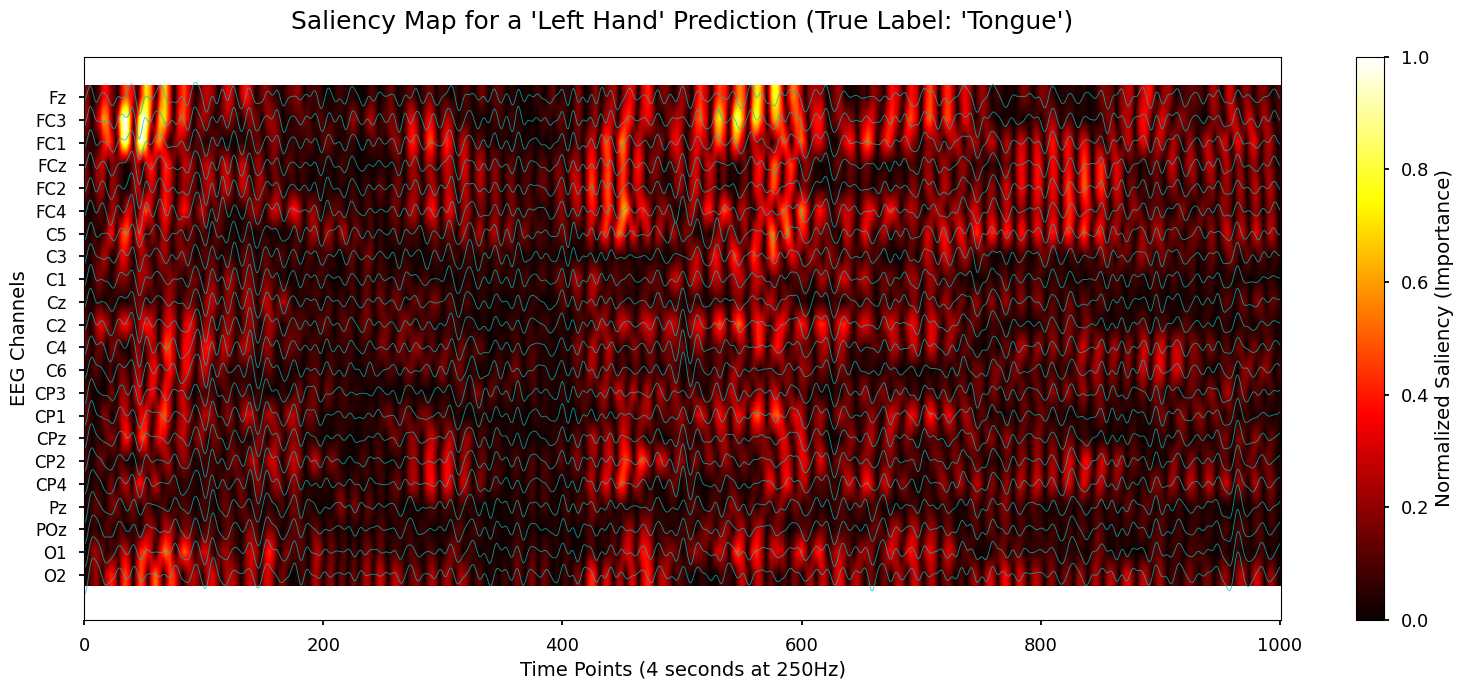

In [17]:
#Explainable AI (XAI) with Saliency Maps

# --- 1. Select a Sample for Explanation ---
# Let's take a sample from the validation set of our balanced data
sample_idx = 10 # Using a different index for variety
input_sample = X_val_t[sample_idx].unsqueeze(0).to(device)
true_label = y_val_t[sample_idx].item()

# Use the balanced model and put it in evaluation mode
model_balanced.eval()

# We need to enable gradients for the input tensor to calculate saliency
input_sample.requires_grad = True

# --- 2. Get Model Prediction ---
output = model_balanced(input_sample)
_, predicted_label = torch.max(output, 1)

# --- 3. Calculate Saliency Map ---
# We want the gradient of the score for the predicted class with respect to the input
output_for_grad = output[0, predicted_label.item()]
output_for_grad.backward()

# The saliency map is the absolute value of the gradient of the input
saliency = input_sample.grad.abs().squeeze(0).cpu().numpy()

# Normalize the saliency map for better visualization (0 to 1)
saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

# --- 4. Visualization ---
# Get the original EEG data for this sample
eeg_data = X_val[sample_idx]
class_names = ['Left Hand', 'Right Hand', 'Feet', 'Tongue']
# Get the list of channel names we created during preprocessing
channel_names = list(new_names.values()) 

# Create the plot
fig, ax = plt.subplots(figsize=(16, 7))
# Plot the saliency map as a heatmap
im = ax.imshow(saliency, cmap='hot', aspect='auto', interpolation='bilinear', 
               extent=[0, eeg_data.shape[1], len(channel_names)-0.5, -0.5])

# Overlay the original EEG data as lines for context
time_points = np.arange(eeg_data.shape[1])
for i in range(eeg_data.shape[0]):
    # Normalize each EEG signal for plotting on top of the heatmap
    eeg_plot = (eeg_data[i] - eeg_data[i].mean()) / (4 * eeg_data[i].std()) + i
    ax.plot(time_points, eeg_plot, color='c', linewidth=0.6, alpha=0.8)

# --- Formatting the Plot ---
ax.set_yticks(np.arange(len(channel_names)))
ax.set_yticklabels(channel_names, fontsize=12)
ax.set_xlabel("Time Points (4 seconds at 250Hz)", fontsize=14)
ax.set_ylabel("EEG Channels", fontsize=14)
ax.set_title(f"Saliency Map for a '{class_names[predicted_label.item()]}' Prediction (True Label: '{class_names[true_label]}')", fontsize=18, pad=20)
fig.colorbar(im, ax=ax, label="Normalized Saliency (Importance)")

plt.tight_layout()
plt.show()